In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [5]:
if (torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cuda Tesla T4


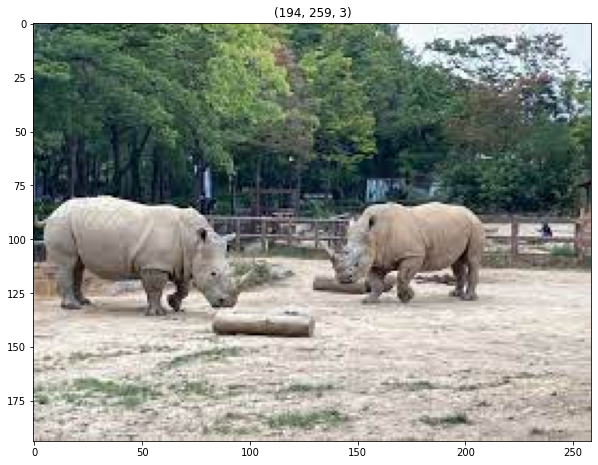

In [6]:
img = cv2.imread('/content/zoo.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title(img.shape)
plt.show()

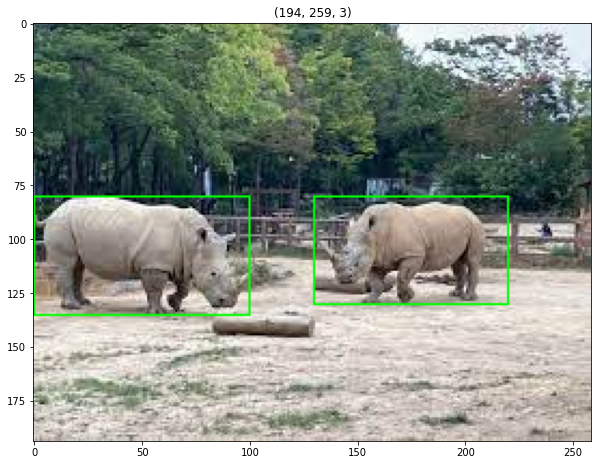

In [7]:
boxes = np.array([[0, 80, 100, 135], [130, 80, 220, 130]])
copy_img = img.copy()

for box in boxes:
  cv2.rectangle(copy_img, (box[0],box[1]), (box[2],box[3]), color=(0,255,0), thickness=1)

plt.figure(figsize=(10,10))
plt.imshow(copy_img)
plt.title(copy_img.shape)
plt.show()

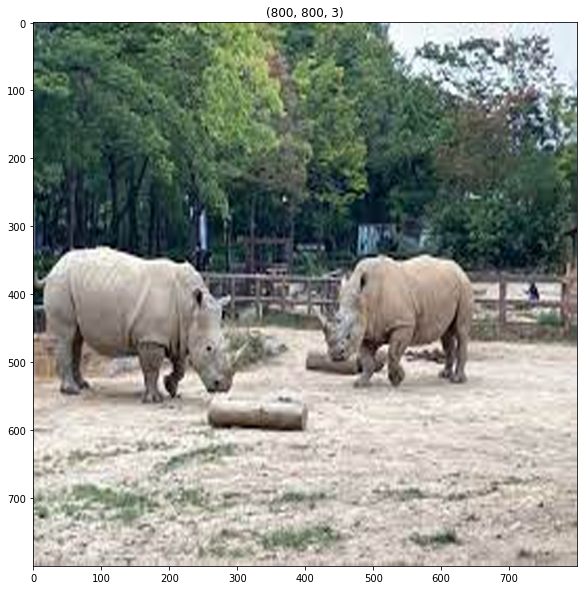

In [8]:
# Resize Image & Bounding box
draw_img = cv2.resize(img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.title(draw_img.shape)
plt.show()

In [9]:
width_rartio = 800/img.shape[1]
height_ration = 800/img.shape[0]

print("width_rartio: {}\nheight_ration: {}".format(width_rartio, height_ration))

bound_boxes = []
for box in boxes:
  x1 = int(box[0]*width_rartio)
  y1 = int(box[1]*height_ration)
  x2 = int(box[2]*width_rartio)
  y2 = int(box[3]*height_ration)
  bound_boxes.append([x1, y1, x2, y2])
print(bound_boxes)

width_rartio: 3.088803088803089
height_ration: 4.123711340206185
[[0, 329, 308, 556], [401, 329, 679, 536]]


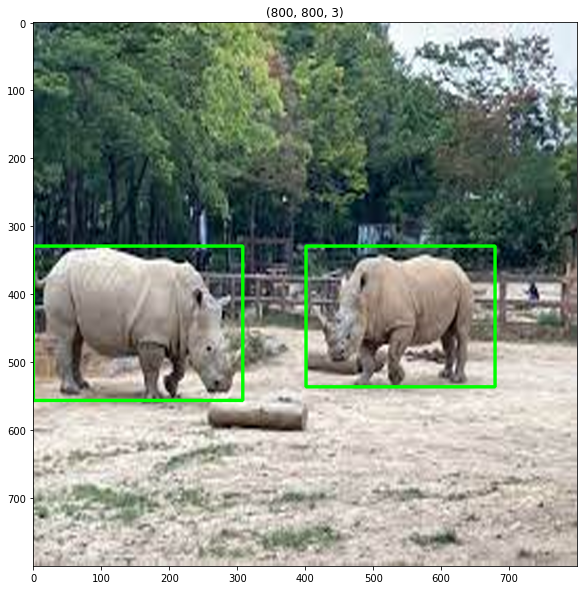

In [10]:
image = draw_img.copy()

for box in bound_boxes:
  cv2.rectangle(image, (box[0],box[1]), (box[2],box[3]), color=(0,255,0), thickness=3)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title(image.shape)
plt.show()

### Load Pre trained model "VGG16"

In [11]:
model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [12]:
## 원본 모델 layers
for feature in features:
  print(feature)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

In [24]:
dummy_img = torch.zeros((1,3,800,800)).float()
print("Dummy img shape: {}".format(dummy_img.shape))

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
  output = feature(output)

  # 원본이미지의 크기가 50*50이 될때까지만 feature extractor로 사용함
  if output.size()[2] < 800//16:
    break
  req_features.append(feature)
  out_channels = output.size()[1]

faster_rcnn_feature_extractor = nn.Sequential(*req_features)

Dummy img shape: torch.Size([1, 3, 800, 800])


### Test model with test data and plot feature maps

In [25]:
# 테스트이미지를 모델에 넣어 feature extractor를 해본다

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(image).to(device)
imgTensor = imgTensor.unsqueeze(0)

output_map = faster_rcnn_feature_extractor(imgTensor)
print("Output size : {}".format(output_map.shape))

Output size : torch.Size([1, 512, 50, 50])


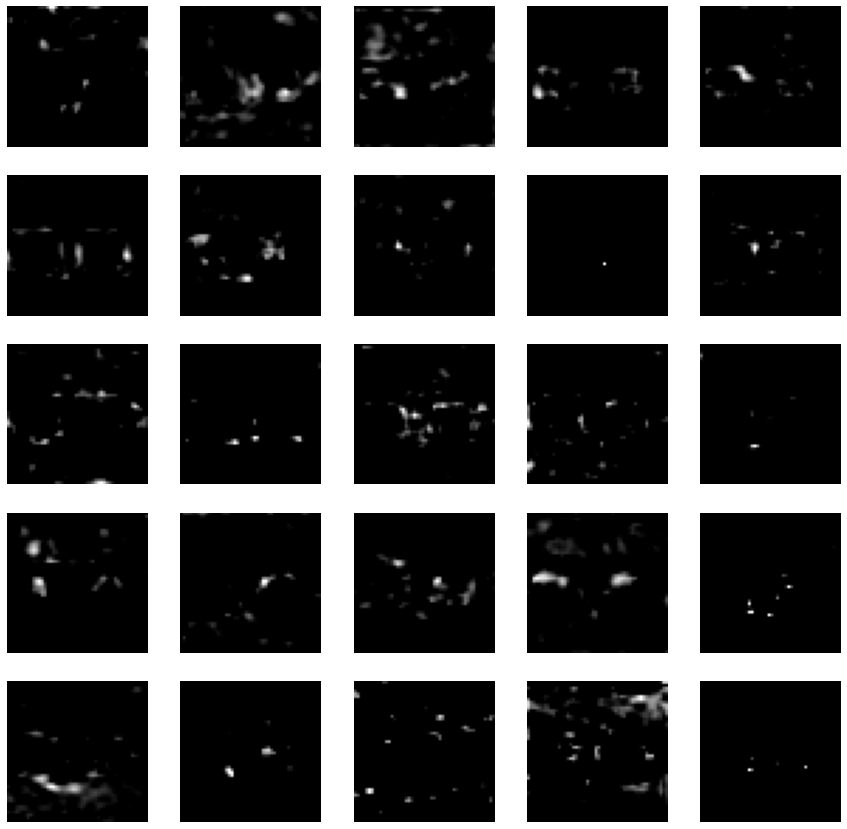

In [26]:
# feature map을 시각화

# Batch shape를 잠시 제거
img_array = output_map.data.cpu().numpy().squeeze(0)

fig , axes = plt.subplots(5, 5, figsize=(15,15))

x_idx = 0
y_idx = 0

for i in range(5*5):
    if x_idx == 5:
        x_idx = 0
        y_idx += 1
        
    axes[y_idx][x_idx].imshow(img_array[i], 'gray')
    axes[y_idx][x_idx].axis("off")
    x_idx += 1

plt.show()

#### Anchor 생성
#### 50 * 50 = 2500 앵커

In [28]:
feature_size = 800//16
print("Feature maps size : {}".format(feature_size))
center_x = np.arange(16,(feature_size+1)*16, 16)
center_y = np.arange(16,(feature_size+1)*16, 16)
print(len(center_x))
print(center_x)

Feature maps size : 50
50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [29]:
index = 0
center = np.zeros((2500,2))

for i in range(len(center_x)):
  for j in range(len(center_y)):
    center[index, 0] = center_x[i] - 8
    center[index, 1] = center_y[j] - 8
    index += 1
print("Center Shape: {}".format(center.shape))
print(center[:10])

Center Shape: (2500, 2)
[[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 [  8.  56.]
 [  8.  72.]
 [  8.  88.]
 [  8. 104.]
 [  8. 120.]
 [  8. 136.]
 [  8. 152.]]


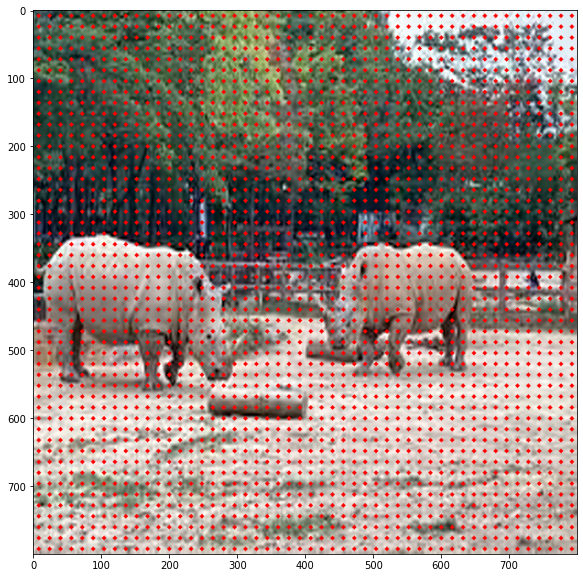

In [30]:
img_copy2 = np.copy(draw_img)
center_int = center.astype("int32")

plt.figure(figsize=(10,10))
for o in center_int:
  cv2.circle(img_copy2, (o[0],o[1]), radius=1,
             color=(255,0,0), thickness=3)

plt.imshow(img_copy2)
plt.show()

#### Anchor Box 생성
#### 50 * 50 = 2500 앵커박스 * 9개의 모양 = 22500 개의 앵커 박스

In [31]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
feature_size = 800 // 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in center:
  sam_center_x, sam_center_y = c
  for ratio in ratios:
    for scale in scales:

      h = sub_sample * scale * np.sqrt(ratio)
      w = sub_sample * scale * np.sqrt(1./ratio)

      anchor_boxes [index, 0] = sam_center_x - w/2.
      anchor_boxes [index, 1] = sam_center_y - h/2.
      anchor_boxes [index, 2] = sam_center_x + w/2.
      anchor_boxes [index, 3] = sam_center_y + h/2.
      index +=1

print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


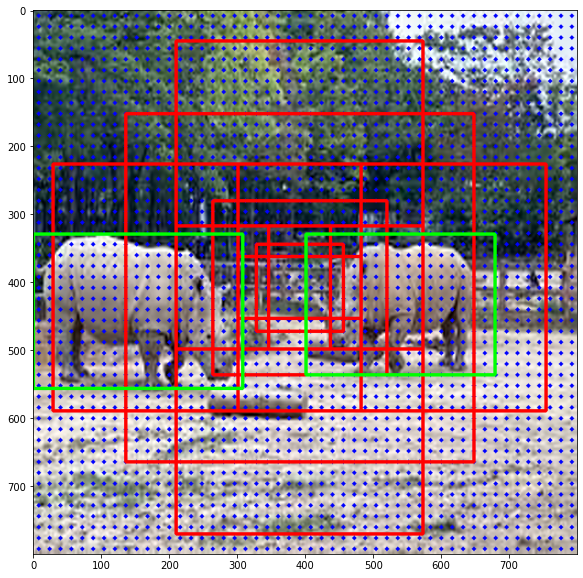

In [32]:
img_copy2 = np.copy(draw_img)
center_int = center.astype("int32")

plt.figure(figsize=(10,10))

for o in center_int:
  cv2.circle(img_copy2, (o[0],o[1]), radius=1,
             color=(0,0,255), thickness=3)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    cv2.rectangle(img_copy2, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)
    
for box in bound_boxes:
  cv2.rectangle(img_copy2, (box[0],box[1]), (box[2],box[3]), color=(0,255,0), thickness=3)

plt.imshow(img_copy2)
plt.show()

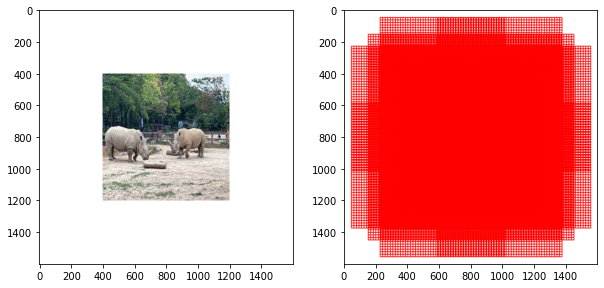

In [33]:
## 모든 Anchor box들 출력
## 이미지 사이즈보다 큰 Anchor box를 그릴 수 없기떄문에 padding을 추가해줌
img_copy3 = np.copy(draw_img)
img_copy4 = cv2.copyMakeBorder(img_copy3, 400, 400, 400, 400,
                               cv2.BORDER_CONSTANT, value=(255,255,255))
img_copy5 = np.copy(img_copy4)

for anchor in anchor_boxes:
  x1 = int(anchor[0])
  y1 = int(anchor[1])
  x2 = int(anchor[2])
  y2 = int(anchor[3])

  cv2.rectangle(img_copy5, (x1+400, y1+400), (x2+400, y2+400), color=(255,0,0), thickness=3)

fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(img_copy4)
axes[1].imshow(img_copy5)
plt.show()

### Target 값에 속하는 Anchor box 시각화

In [34]:
# 이미지 안에 속해있는 Anchor box들의 인덱스를 추출

index_inside = np.where(
    (anchor_boxes[:, 0] >=0) &
    (anchor_boxes[:, 1] >=0) &
    (anchor_boxes[:, 2] <=800) &
    (anchor_boxes[:, 3] <=800))[0]

print(index_inside.shape)
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [36]:
ious = np.empty((len(valid_anchor_boxes),2), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bound_boxes):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [39]:
# Neg / Pos 구별
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[ 607 6620]
[0.7513835 0.7560565]
[ 607  612  793  798  979  984 6620 6628 6636 6643]


In [118]:
a = np.random.randn(2,2)
b = np.random.randn(2)
print(a, b)
print(sum(a,b))
#print(a.argmax(axis=1))

[[-0.15281331  0.02801267]
 [-0.40435551  0.26676083]] [0.15275794 1.5698378 ]
[-0.40441088  1.8646113 ]


In [46]:
ious[[607, 6620],[0,1]]

array([0.7513835, 0.7560565], dtype=float32)

In [52]:
argmax_ious = ious.argmax(axis=1)
print("argmax_ious shape : ", argmax_ious)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

argmax_ious shape :  [0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [68]:
label = np.zeros_like(index_inside)
label.fill(-1)
print(label.shape)
print(label[:10])

(8940,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [69]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0
print(label[:10])

[0 0 0 0 0 0 0 0 0 0]


In [71]:
# 매번 배치적으로 학습을 한다 256개의 vaild anchor box와 함께
n_samples = 256

# postive data sampling
pos_ratio = 0.5
n_pos = pos_ratio * n_samples

pos_index = np.where(label == 1)
if len(pos_index) > n_pos:
  disable_index = np.random.choice(pos_index,
                                  size=(len(pos_index) - n_pos),
                                  replace=False)
  label[disable_index] = -1

# negative data sampling
neg_ratio = 0.5
n_neg = n_samples * np.sum(label == 1)

neg_index = np.where(label == 0)
if len(neg_index) > n_pos:
  disable_index = np.random.choice(pos_index,
                                  size=(len(neg_index) - n_pos),
                                  replace=False)
  label[disable_index] = -1

In [73]:
len(label)

8940

In [75]:
np.where(label==1)

(array([ 602,  607,  612,  788,  793,  798,  974,  979,  984, 1184, 1191,
        1197, 6374, 6382, 6390, 6397, 6620, 6628, 6636, 6643, 6857, 6864,
        6871, 6877]),)

In [78]:
index_inside[602]

3838